# Playing around with the trees

In [1]:
import os, sys
import numpy as np
import uproot
import pandas as pd

In [2]:
indir = '/mnt/d/work/GitHub/VLLSearch-Run3/AnaCodes/prachu/TreeMaker/test_outputs'
branches = [
    'nlep', 'njet', 'nbjet',
    'met', 'metphi',
    'lep0_pt', 'lep0_eta', 'lep0_phi', 'lep0_mt',
    'lep1_pt', 'lep1_eta', 'lep1_phi', 'lep1_mt',
    'll_pt', 'll_mass', 'll_deta', 'll_dphi', 'll_dr',
    'ht', 'stfrac',
    'dphi_metlep0', 'dphi_metlep1', 'dphi_metlep_max', 'dphi_metlep_min'
]

def read_file_into_df(name, truth):
    file = uproot.open(f'{indir}/{name}')
    tree = file['Events']
    awkarray = tree.arrays(branches)
    df = pd.DataFrame(awkarray.to_list())
    df['truth'] = truth
    return df

In [3]:
%%time
df_bkg = read_file_into_df('tree_zz.root', 0)
df_sig = read_file_into_df('tree_vlld_ele_800.root', 1)
df = pd.concat([df_sig, df_bkg])
df = df.sample(frac=1).reset_index(drop=True) #Randomizing the rows and reseting the indices
df

CPU times: user 1min 10s, sys: 1.63 s, total: 1min 12s
Wall time: 1min 12s


,nlep,njet,nbjet,met,metphi,lep0_pt,lep0_eta,lep0_phi,lep0_mt,lep1_pt,...,ll_deta,ll_dphi,ll_dr,ht,stfrac,dphi_metlep0,dphi_metlep1,dphi_metlep_max,dphi_metlep_min,truth
0,2,2,0,38.165337,0.745728,13.045717,-0.155426,0.654419,2.049025,38.628593,...,2.138031,0.692993,2.247535,143.12500,0.256488,0.091309,0.601685,0.601685,0.091309,0
1,2,1,0,41.353111,0.121536,33.714500,0.838501,1.429443,53.224052,19.855742,...,0.439087,2.420044,2.459555,35.96875,0.389300,1.307907,1.112137,1.307907,1.112137,0
2,2,6,0,234.262115,-0.478027,125.634270,0.792847,0.946777,258.756226,96.510315,...,2.826538,2.609131,3.846672,656.75000,0.089868,1.424805,1.184326,1.424805,1.184326,1
3,2,2,0,9.351761,0.967163,27.809313,0.079727,3.108398,28.347082,32.934158,...,1.521378,3.056450,3.414158,69.00000,0.076748,2.141235,0.915215,2.141235,0.915215,0
4,2,4,0,259.829559,1.199219,51.836369,0.052216,2.417480,132.892792,30.309578,...,1.673065,0.124512,1.677692,652.00000,0.111714,1.218262,1.093750,1.218262,1.093750,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6552,2,2,0,42.271629,-1.155029,33.381367,0.805786,-1.495605,14.752417,44.635143,...,1.119751,2.076294,2.358991,91.59375,0.308104,0.340576,1.735718,1.735718,0.340576,0
6553,2,1,0,11.045397,-0.808228,33.442970,0.138947,2.483887,38.515224,27.429718,...,0.841766,2.873029,2.993805,35.46875,0.221572,2.991071,0.118042,2.991071,0.118042,0
6554,2,5,2,132.778107,2.072266,115.971275,1.247070,-1.743164,321.476013,33.966228,...,0.856445,0.916992,1.254740,383.71875,0.266289,2.467756,2.898437,2.898437,2.467756,1
6555,2,4,0,94.170128,2.929688,427.588165,0.191589,-2.915039,88.079529,262.802887,...,0.771545,1.276349,1.491426,1399.90625,0.286868,0.438459,0.837891,0.837891,0.438459,1


#### Plotting the variables

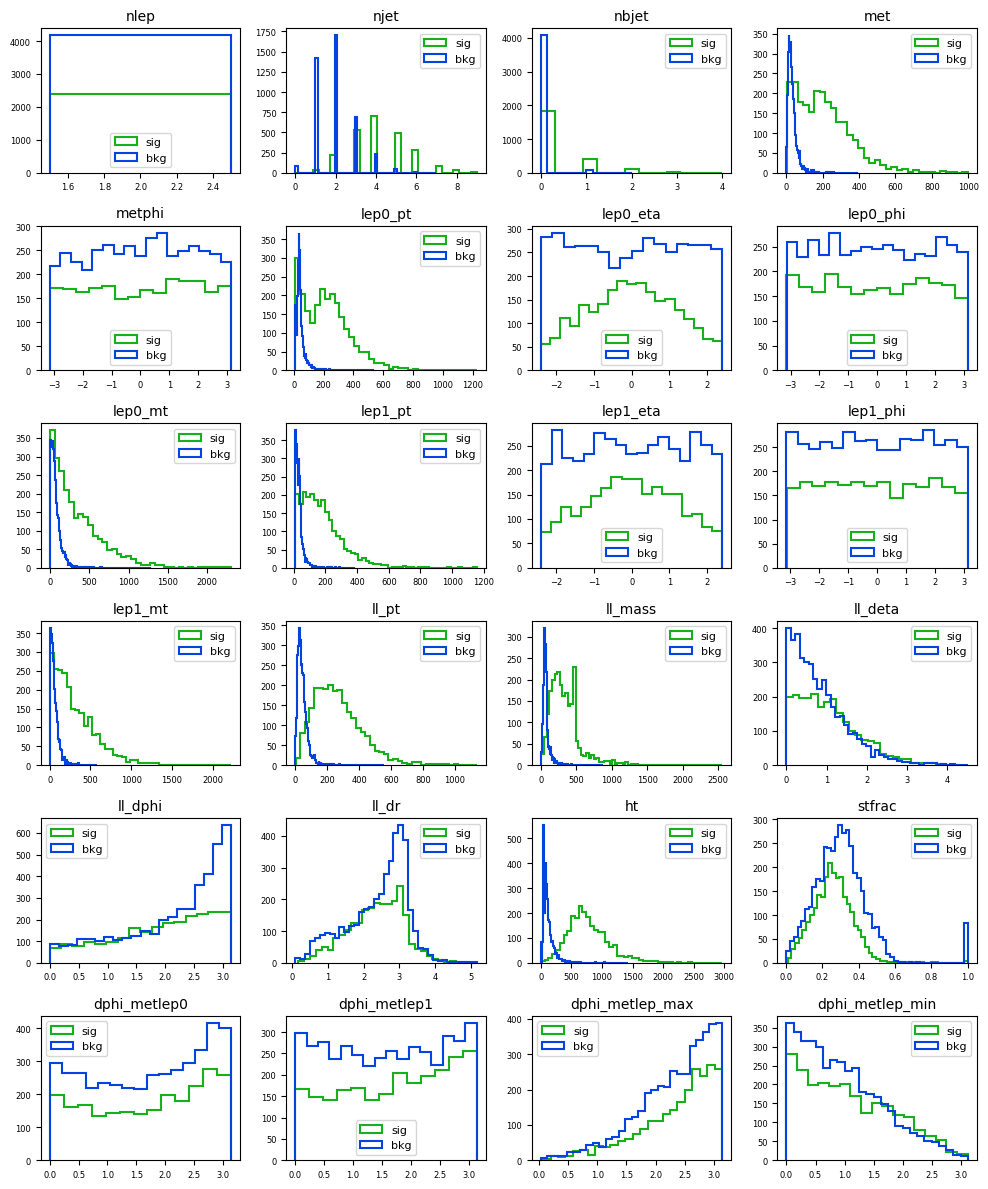

In [4]:
import matplotlib.pyplot as plt

decorate_hist = {
    'bins':'auto',
    'histtype':'step',
    'linewidth':1.5,
    'density':False,
    'log':False
}

fig, ax = plt.subplots(6, 4, figsize=(10, 12))
ax = ax.flatten()

for i, var in enumerate(branches):
    ax[i].hist(df[df['truth'] == 1][var], label='sig', color='xkcd:green', **decorate_hist)
    ax[i].hist(df[df['truth'] == 0][var], label='bkg', color='xkcd:blue',  **decorate_hist)
    ax[i].set_title(var, fontsize=10)
    ax[i].legend(loc='best', fontsize=8)
    ax[i].tick_params(axis='both', labelsize=6)

plt.tight_layout()
#plt.savefig('combined_plot.png')
plt.show()

# The Neural Network

In [5]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

2023-11-23 15:49:46.268356: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Prepating the dataframe for training and testing:

In [6]:
df_train, df_test = train_test_split(df, test_size=0.5, stratify=df['truth'])
del df
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test  = df_test.sample(frac=1).reset_index(drop=True)

nsig_train = len(df_train.query('truth == 1'))
nsig_test  = len(df_test.query('truth == 1'))
nbkg_train = len(df_train.query('truth == 0'))
nbkg_test  = len(df_test.query('truth == 0'))

print(f'Statistics:')
print(f'nSig split into train and test: {nsig_train}, {nsig_test}')
print(f'nBkg split into train and test: {nbkg_train}, {nbkg_test}')

train_var = ['met','lep0_pt','ll_pt','ll_mass','ht']

#Numpy arrays that go into the training and testing:
X_train= df_train[train_var].values
y_train= df_train['truth'].values
X_test = df_test[train_var].values
y_test = df_test['truth'].values

Statistics:
nSig split into train and test: 1189, 1190
nBkg split into train and test: 2089, 2089


#### Min-max scaler:

In [7]:
def ScaleMinMax(x):
    maxval = x.max(axis=0)
    minval = x.min(axis=0)
    print('\n'+'-'*25)
    print('Before scaling:')
    print("Min Values:", minval)
    print("Max Values:", maxval)
    diff = maxval-minval
    # Identifying columns where
    # max and min values are different:
    nonconst = np.where(diff != 0)[0]
    
    # Normalizing only those columns:
    normed_x = x.copy()
    normed_x[:, nonconst] = 2 * ((x[:, nonconst] - minval[nonconst]) / diff[nonconst]) - 1.0
    #normed_x[:, nonconst] = -1 + 2 * ((x[:, nonconst] - minval[nonconst]) / diff[nonconst])
    
    maxval_new = normed_x.max(axis=0)
    minval_new = normed_x.min(axis=0)
    print('\nAfter scaling:')
    print("Min Values:", minval_new)
    print("Max Values:", maxval_new)
    return normed_x

In [8]:
X_train = ScaleMinMax(X_train)
X_test = ScaleMinMax(X_test)


-------------------------
Before scaling:
Min Values: [ 0.21899335 10.02939892  0.48480967  2.34793019  0.        ]
Max Values: [ 998.69714355 1228.51965332 1138.60986328 2560.96362305 2883.5       ]

After scaling:
Min Values: [-1. -1. -1. -1. -1.]
Max Values: [1. 1. 1. 1. 1.]

-------------------------
Before scaling:
Min Values: [ 0.67970288 10.02855206  0.45234707  2.50284839  0.        ]
Max Values: [ 907.82629395 1028.68554688 1011.67822266 1784.73168945 2970.875     ]

After scaling:
Min Values: [-1. -1. -1. -1. -1.]
Max Values: [1. 1. 1. 1. 1.]


### Model architecture

In [9]:
n_features = X_train.shape[1]
epochs_ = 10
batch_ = 100

model = Sequential()
model.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_dim=n_features, name='FirstLayer'))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid', name='FinalLayer'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#opt = tf.keras.optimizers.Adam(learning_rate=0.001)
print('The NN architecture is')
model.summary()

The NN architecture is
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FirstLayer (Dense)          (None, 64)                384       
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 FinalLayer (Dense)          (None, 1)                 17        
                                                                 
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


2023-11-23 15:49:50.803677: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
history = model.fit(X_train,y_train,epochs=epochs_,batch_size=batch_,validation_data=(X_test,y_test),verbose=1)
#model.save('models/'+ modelname +f'/{modelname}.h5')
print('Training complete!')

Epoch 1/10
33/33 [==============================] - 2s 46ms/step - loss: 0.5478 - accuracy: 0.6483 - val_loss: 0.4855 - val_accuracy: 0.6841
Epoch 2/10
33/33 [==============================] - 1s 19ms/step - loss: 0.4358 - accuracy: 0.7605 - val_loss: 0.3904 - val_accuracy: 0.7969
Epoch 3/10
33/33 [==============================] - 1s 19ms/step - loss: 0.3248 - accuracy: 0.8743 - val_loss: 0.2825 - val_accuracy: 0.9042
Epoch 4/10
33/33 [==============================] - 1s 16ms/step - loss: 0.2171 - accuracy: 0.9332 - val_loss: 0.1917 - val_accuracy: 0.9332
Epoch 5/10
33/33 [==============================] - 0s 11ms/step - loss: 0.1502 - accuracy: 0.9527 - val_loss: 0.1472 - val_accuracy: 0.9418
Epoch 6/10
33/33 [==============================] - 0s 13ms/step - loss: 0.1239 - accuracy: 0.9579 - val_loss: 0.1203 - val_accuracy: 0.9561
Epoch 7/10
33/33 [==============================] - 0s 13ms/step - loss: 0.1086 - accuracy: 0.9625 - val_loss: 0.1032 - val_accuracy: 0.9643
Epoch 8/10
33

### Plotting loss and accuracy of the NN as a function of epochs

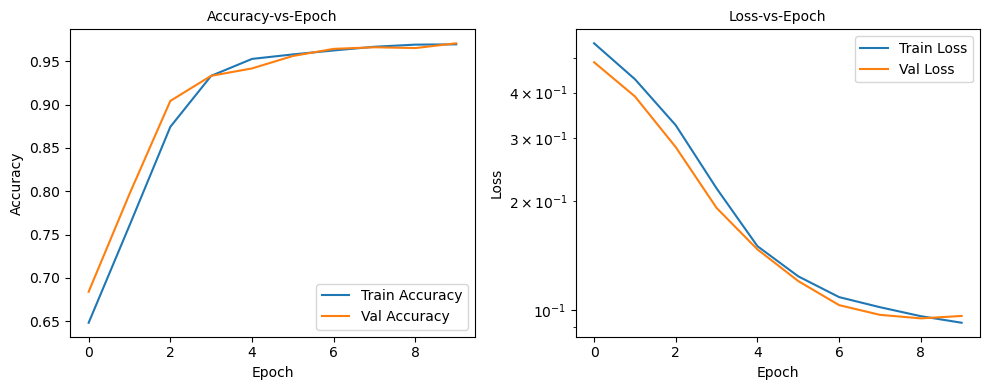

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Subplot 1: accuracy vs epoch
ax[0].plot(history.history['accuracy'],     label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy-vs-Epoch', fontsize=10)
ax[0].legend(loc='best')

# Subplot 2: loss vs epoch
ax[1].plot(history.history['loss'],     label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')
ax[1].legend(loc='best')
ax[1].set_title('Loss-vs-Epoch', fontsize=10)

plt.tight_layout()
#plt.savefig('combined_plot.png')
plt.show()

### Using the trained model to predict

In [12]:
y_predicted_train = model.predict(X_train)
y_predicted_test  = model.predict(X_test)

df_train['score'] = y_predicted_train
df_test['score']  = y_predicted_test

# ROC information for the test dataset
fpr, tpr, _ = roc_curve(y_test, y_predicted_test)
auc_score = auc(tpr,1-fpr)
tpr=tpr*100
fnr=(1-fpr)*100

# ROC information for training data
fpr1, tpr1, _ = roc_curve(y_train, y_predicted_train)
auc_score1 = auc(tpr1,1-fpr1)
tpr1=tpr1*100
fnr1=(1-fpr1)*100

103/103 [==============================] - 0s 4ms/step


In [13]:
display(df_test)

,nlep,njet,nbjet,met,metphi,lep0_pt,lep0_eta,lep0_phi,lep0_mt,lep1_pt,...,ll_dphi,ll_dr,ht,stfrac,dphi_metlep0,dphi_metlep1,dphi_metlep_max,dphi_metlep_min,truth,score
0,2,6,2,43.345596,-1.777832,337.794708,-0.861084,-0.157745,206.977097,90.086548,...,2.558563,2.960305,1756.375000,0.132058,1.620087,0.938477,1.620087,0.938477,1,0.998638
1,2,6,0,366.967377,2.951172,58.371822,-0.246735,2.229004,104.982994,180.935730,...,2.937011,2.960395,700.093750,0.150827,0.722168,2.624006,2.624006,0.722168,1,0.998283
2,2,3,0,202.152939,-2.189453,462.658356,1.738037,2.199219,850.095093,407.860840,...,1.157227,1.165947,1587.500000,0.314827,1.894514,3.051740,3.051740,1.894514,1,0.998836
3,2,2,0,217.090485,-2.887695,15.661216,0.982788,1.532715,115.489891,37.108837,...,0.578125,2.454197,269.187500,0.159147,1.862775,2.440900,2.440900,1.862775,1,0.967504
4,2,1,0,8.275390,-2.043945,27.710875,1.109863,0.387695,36.827877,20.115877,...,2.851545,3.323442,31.359375,0.245620,2.431640,1.000000,2.431640,1.000000,0,0.011011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,2,5,0,399.970490,0.470642,248.030975,0.008869,-0.884644,394.951874,69.673660,...,0.949493,2.579617,1019.500000,0.223886,1.355286,0.405792,1.355286,0.405792,1,0.994280
3275,2,2,0,35.193207,0.152496,10.067788,1.318115,0.313904,4.294218,38.971622,...,0.036804,0.873091,123.843750,0.283634,0.161407,0.124603,0.161407,0.124603,0,0.032952
3276,2,3,0,35.559174,0.826782,36.475395,-2.094727,0.696777,9.500480,21.694073,...,1.714111,1.714322,136.375000,0.225415,0.130005,1.844116,1.844116,0.130005,0,0.022367
3277,2,2,0,14.169917,-2.021484,45.729931,2.157715,-2.187988,8.863705,63.434135,...,2.825073,2.826278,130.750000,0.157964,0.166504,2.658569,2.658569,0.166504,0,0.021148


In [14]:
%%capture

mybins = np.arange(0, 1.02, 0.02)

testsig = plt.hist(df_test[df_test['truth']==1]['score'], bins=mybins, density=False)
counts_sig, bins_sig, _ = testsig
errors_sig = np.sqrt(counts_sig)

testbkg = plt.hist(df_test[df_test['truth']==0]['score'], bins=mybins, density=False)
counts_bkg, bins_bkg, _ = testbkg
errors_bkg = np.sqrt(counts_bkg)

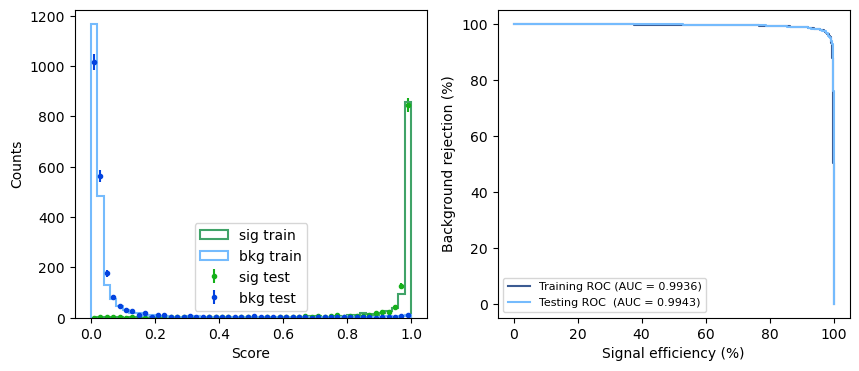

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

decorate_hist = {
    'bins':mybins,
    'histtype':'step',
    'linewidth':1.5,
    'density':False,
    'log':False
}

decorate_point ={
    'marker':'o',
    'markersize':3,
    'linestyle':''
}

ax[0].errorbar(bins_sig[:-1]+np.diff(bins_sig)/2, counts_sig, yerr=errors_sig, color='xkcd:green', label='sig test', **decorate_point)
ax[0].errorbar(bins_bkg[:-1]+np.diff(bins_bkg)/2, counts_bkg, yerr=errors_bkg, color='xkcd:blue',  label='bkg test', **decorate_point)
trainsig = ax[0].hist(df_train[df_train['truth'] == 1]['score'], color='xkcd:greenish', label='sig train', **decorate_hist)
trainbkg = ax[0].hist(df_train[df_train['truth'] == 0]['score'], color='xkcd:sky blue', label='bkg train', **decorate_hist)
ax[0].set_xlabel('Score')
ax[0].set_ylabel('Counts')
ax[0].legend(loc='best')

ax[1].plot(tpr, fnr, color='xkcd:denim blue', label='Training ROC (AUC = %0.4f)' % auc_score)
ax[1].plot(tpr1,fnr1,color='xkcd:sky blue',   label='Testing ROC  (AUC = %0.4f)'  % auc_score1)
ax[1].set_xlabel('Signal efficiency (%)')
ax[1].set_ylabel('Background rejection (%)')
ax[1].legend(loc='best', fontsize=8)

plt.show()